In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping 
from keras.wrappers.scikit_learn import KerasRegressor

In [2]:
df = pd.read_csv('/content/hourly_nm.csv',index_col='Datetime')
df.head()

,Power,Wind_speed,Theoretical_power,Loss_power,x_com,y_com,T_1
Datetime,,,,,,,
2018-01-01 02:00:00,733.655375,6.452037,788.401310,54.745935,-0.176225,-6.440522,460.537125
2018-01-01 03:00:00,909.362081,6.811455,948.793346,39.431265,-1.652917,-6.596464,733.655375
2018-01-01 04:00:00,1393.518188,7.748749,1406.391795,12.873607,-2.912491,-7.138868,909.362081
2018-01-01 05:00:00,1149.599162,7.236854,1128.194441,-21.404721,-3.170687,-6.478943,1393.518188
2018-01-01 06:00:00,1100.074392,7.183671,1103.372815,3.298423,-2.907223,-6.565457,1149.599162


In [4]:
print(df.info())
print('\t ----------------------------------------------')
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 8758 entries, 2018-01-01 02:00:00 to 2018-12-31 23:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Power              8758 non-null   float64
 1   Wind_speed         8758 non-null   float64
 2   Theoretical_power  8758 non-null   float64
 3   Loss_power         8758 non-null   float64
 4   x_com              8758 non-null   float64
 5   y_com              8758 non-null   float64
 6   T_1                8758 non-null   float64
dtypes: float64(7)
memory usage: 547.4+ KB
None
	 ----------------------------------------------
             Power   Wind_speed  Theoretical_power   Loss_power        x_com  \
count  8758.000000  8758.000000        8758.000000  8758.000000  8758.000000   
mean   1318.239139     7.463251        1477.410969   159.171830     0.425461   
std    1272.193961     4.162011        1335.035360   316.048955     6.454121   
min      -0.17952

Spliting Dataset

In [21]:
start_test = '2018-11-31'

train, test = df.loc[:start_test], df.loc[start_test:]

In [22]:

print(f'data train: {len(train)} data')
print(f'data test: {len(test)} data')


data train: 8014 data
data test: 744 data


In [23]:
#skala data menggunakan MinMax Scaler dari -1 ke 1 karena LSTM memiliki fungsi aktivasi tanh default

SCALER = MinMaxScaler(feature_range=(-1,1))

scaler = SCALER.fit(train.to_numpy())

train_scaled = scaler.transform(train.to_numpy())
test_scaled = scaler.transform(test.to_numpy())

In [24]:
#membuat func untuk split data menjadi 2 minggu 
timestep = 24*7*2 

def create_dataset(dataset, timestep=timestep):

    X, y = [], []
    for i in range(len(dataset)):
        target_value = i + timestep
        if target_value == len(dataset):
            break
        feature_chunk, target = dataset[i:target_value, 1:], dataset[target_value, 0]
        X.append(feature_chunk)
        y.append(target)
    
    return np.array(X), np.array(y) 

In [25]:
#buat  x_train,_y_train,x_test,dan y_test
X_train, y_train = create_dataset(train_scaled)
X_test, y_test = create_dataset(test_scaled)

In [26]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7678, 336, 6)
(7678,)
(408, 336, 6)
(408,)


In [28]:
#gunakan sampel data untuk melatih jaringan agar memiliki pemahaman kasar tentang hyperparameter
samp_len = int(len(X_train)*0.5)

X_sample_train, y_sample_train = X_train[:samp_len], y_train[:samp_len]

In [29]:
print(X_sample_train.shape)
print(y_sample_train.shape)

(3839, 336, 6)
(3839,)


In [31]:
#membuat func model LSTM  dan input berupa [samples,timesteps,features]]
def create_model(X_train, y_train):
        units = 32
        dropout = 0.05
        epochs = 30
        batch_size = 16
        optimizer = keras.optimizers.Adam(learning_rate=0.0005)
        early_stopping = EarlyStopping(patience=7, monitor='loss')

        model = keras.Sequential()

        model.add(LSTM(units=units, dropout=dropout, return_sequences=True,
                       input_shape=(X_train.shape[1], X_train.shape[2])))
        
        model.add(LSTM(units=units, dropout=dropout))
        
        model.add(Dense(units=1))

        model.compile(optimizer=optimizer, loss='mean_squared_error')
        history = model.fit(X_train, y_train, validation_split=0.3, shuffle=False,
                  epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
       
        return model, history

In [32]:
#buat func untuk melakukan predict singel value
def single_prediction(model, history, timestep=timestep):
        
        history = np.array(history)
        history = history.reshape(history.shape[0]*history.shape[1], history.shape[2])
        
        input_value = history[-timestep:]
        input_value = input_value.reshape(1, input_value.shape[0], input_value.shape[1])
        
        yhat = model.predict(input_value, verbose=0)
        return yhat

In [33]:
#membuat fungsi untuk tahapan selanjutnya 
def walk_forward_prediction(X_train, y_train, X_test, timestep):
    
    MODEL, history = create_model(X_train=X_train, y_train=y_train)
    hist_train = [i for i in X_train]
    predictions = []
    
    for i in range(len(X_test)):
        test = X_test[i]
        yhat = single_prediction(model=MODEL, history=hist_train, timestep=timestep)
        predictions.append(yhat) 
        hist_train.append(test)
    
    return predictions, history, MODEL

In [34]:
def prior_inverse(features, targets):
  
    dataset = []
    
    for i in range(features.shape[0]):
        last_row, target = features[i][0], targets[i]
        appended = np.append(last_row, target)
        dataset.append(appended)
    
    return np.array(dataset) 

In [35]:
def experiment(X_train, y_train, X_test, timestep):
    
    pred_seq, history, MODEL = walk_forward_prediction(X_train, y_train, X_test, timestep)
    
    pred_seq = np.array(pred_seq).reshape(-1)

    pred = prior_inverse(X_test, pred_seq)
    real = prior_inverse(X_test, y_test)

    inv_pred = scaler.inverse_transform(pred)
    inv_real = scaler.inverse_transform(real)

    power_pred = inv_pred[:,-1]
    power_real = inv_real[:,-1]
    
    return power_real, power_pred, history, MODEL

In [36]:
power_real, power_pred, history, MODEL = experiment(X_train, y_train, X_test, timestep)

loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/30
336/336 [==============================] - 110s 313ms/step - loss: 0.2464 - val_loss: 0.1804
Epoch 2/30
336/336 [==============================] - 103s 307ms/step - loss: 0.1433 - val_loss: 0.1122
Epoch 3/30
336/336 [==============================] - 101s 302ms/step - loss: 0.1001 - val_loss: 0.0843
Epoch 4/30
336/336 [==============================] - 108s 321ms/step - loss: 0.0876 - val_loss: 0.0814
Epoch 5/30
336/336 [==============================] - 105s 313ms/step - loss: 0.0847 - val_loss: 0.0742
Epoch 6/30
336/336 [==============================] - 102s 305ms/step - loss: 0.0822 - val_loss: 0.0732
Epoch 7/30
336/336 [==============================] - 103s 308ms/step - loss: 0.0821 - val_loss: 0.0748
Epoch 8/30
336/336 [==============================] - 102s 304ms/step - loss: 0.0815 - val_loss: 0.0739
Epoch 9/30
336/336 [==============================] - 101s 301ms/step - loss: 0.0795 - val_loss: 0.0710
Epoch 10/30
336/336 [==============================] - 103s 308m

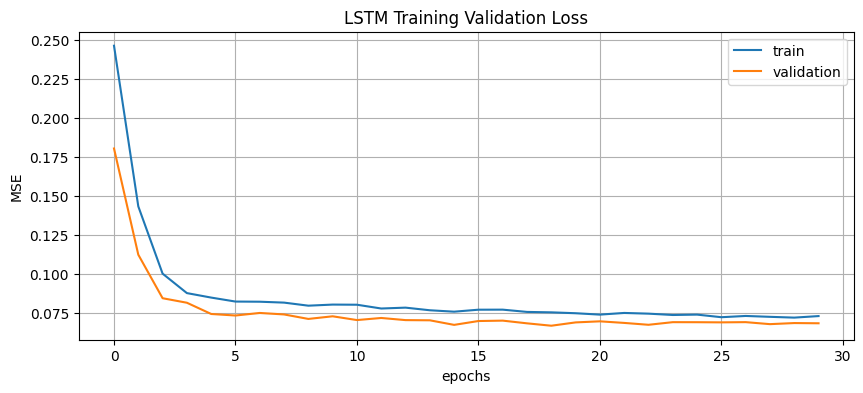

In [37]:
plt.figure(figsize=(10,4))
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('LSTM Training Validation Loss')
plt.show()

In [38]:
x_plot = test[timestep:].index
pred_df = pd.DataFrame({'Date':x_plot, 'Prediction': power_pred, 'True': power_real})
pred_df.set_index('Date', inplace=True)


In [43]:
pred_df2 = pred_df['2018-12-15 01:00:00	':'2018-12-29 02:00:00 ']

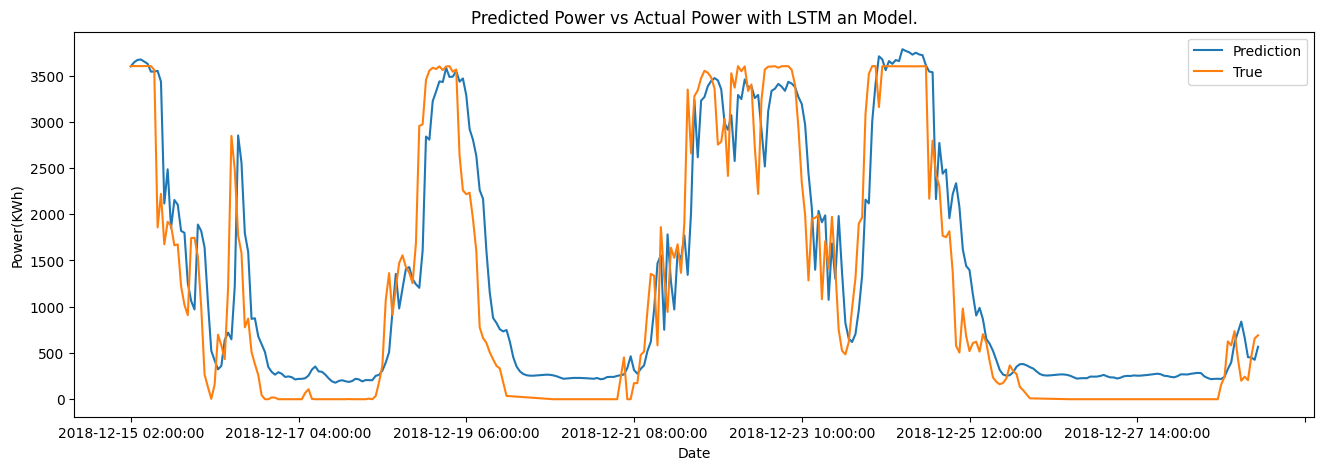

In [46]:
pred_df2.plot(figsize=(16,5))
plt.title('Predicted Power vs Actual Power with LSTM an Model.')
plt.ylabel('Power(KWh)')
plt.show()

In [47]:
#compute metrics
rmse = np.sqrt(mean_squared_error(pred_df2['True'], pred_df2['Prediction']))
mae = mean_absolute_error(pred_df2['True'], pred_df2['Prediction'])
r2 = r2_score(pred_df2['True'], pred_df2['Prediction'])
print('RMSE: {}\nMAE: {}\nR2: {}'.format(round(rmse,2),round(mae,2), round(r2,2)))

RMSE: 521.79
MAE: 382.34
R2: 0.85
